# Single proliferation event within larger spheroid

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.integrate as scpi
import scipy.interpolate as sci

import os 
import json

import cbmos
import cbmos.force_functions as ff
import cbmos.solvers.euler_forward as ef
import cbmos.solvers.euler_backward as eb
import cbmos.cell as cl
import cbmos.utils as ut

plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6.75, 5),
          'lines.linewidth': 3.0, 
          'axes.labelsize': 'xx-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'xx-large', 
          'ytick.labelsize':'xx-large', 
          'legend.fontsize': 'xx-large', 
          'font.size': 11, 
          'font.family': 'serif', 
          'mathtext.fontset': 'dejavuserif', 
          'axes.titlepad': 12, 
          'axes.labelpad': 12}
plt.rcParams.update(params)

from matplotlib import cm
import matplotlib.colors as mcolors

In [2]:
# Simulation parameters
s = 1.0    # rest length
tf = 6.0  # final time
rA = 1.5   # maximum interaction distance

dim = 3
seed = 17

t_data = [0,tf]

#force_names = ['cubic', 'pw. quad.', 'GLS']
force = 'cubic'
# parameters fitted to relaxation time t=1.0h
params_cubic = {"mu": 5.70, "s": s, "rA": rA}

defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'cubic': defcolors[0], 'pw. quad.': defcolors[5], 'GLS': defcolors[6]}


In [3]:
#algorithms
algorithms = ['EF_glob_adap_acc', 'EF_glob_adap_stab' ,  'EF_local_adap', 'EB_global_adap' ]

models = {'EF_glob_adap_acc': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
          'EF_glob_adap_stab': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),  
          'EF_local_adap': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim), 
          'EB_global_adap': cbmos.CBModel(ff.Cubic(), eb.solve_ivp, dim) }

eta = 1e-4

params = {'EF_glob_adap_acc': {'eta': eta},
          'EF_glob_adap_stab': {'eta': eta, 
                                'jacobian': models['EF_glob_adap_stab'].jacobian, 'force_args': params_cubic, 
                                'always_calculate_Jacobian': True, 
                                #'calculate_eigenvalues': True
                               }, 
          'EF_local_adap': {'eta': eta, 
                            'jacobian': models['EF_local_adap'].jacobian, 'force_args': params_cubic, 
                            #'always_calculate_Jacobian': True, 
                            'local_adaptivity': True, 'm0': 14, 
                            #'calculate_eigenvalues': True
                            'dim': dim, 
                            'rA': rA 
                           }, 
          'EB_global_adap': {'eta': eta, 'jacobian': models['EB_global_adap'].jacobian, 'force_args': params_cubic}
         }


labels = {'EF_glob_adap_acc': 'Alg. I (SRFE)', 
          'EF_glob_adap_stab': 'Alg. II (SRFES)' ,  
          'EF_local_adap': 'Alg. III (MRFE)', 
          'EB_global_adap': 'Alg. IV (SRBE)'
         }

In [4]:
cell_list = ut.setup_locally_compressed_spheroid(6, 6, 6, seed=seed)

## Time step sizes as a function of chosen absolute error

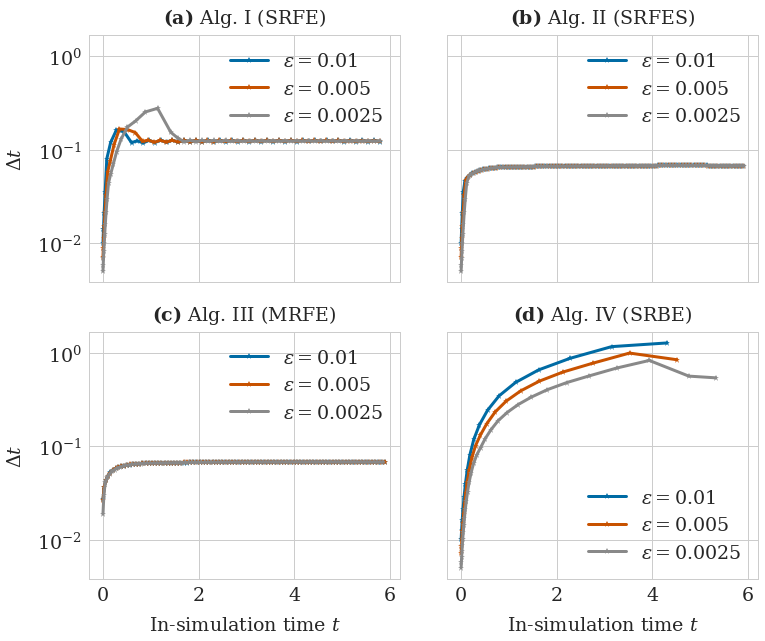

In [5]:
colors = [defcolors[0], defcolors[5], defcolors[6]]

# Combine into single figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True, gridspec_kw={'hspace':0.2, 'wspace': 0.15})
      
axes = {'EF_glob_adap_acc': ax1, 'EF_glob_adap_stab': ax2 ,  'EF_local_adap': ax3, 'EB_global_adap': ax4}

epsilons = [0.01, 0.005, 0.0025]
      
for alg in algorithms:
        
    for i, eps in enumerate(epsilons):
        
        params[alg]['eps'] = eps
        ts, history = models[alg].simulate(cell_list, t_data, params_cubic, params[alg], seed=seed)

        axes[alg].semilogy(ts[:-2], np.diff(ts)[:-1],'-*', label='$\epsilon=$'+str(eps), color=colors[i]) # last dt smaller to reach end time exactly - do not plot
        
    axes[alg].legend()
   

ax1.set_title(r'$\bf{(a)}$ Alg. I (SRFE)')
ax2.set_title(r'$\bf{(b)}$ Alg. II (SRFES)')
ax3.set_title(r'$\bf{(c)}$ Alg. III (MRFE)')
ax4.set_title(r'$\bf{(d)}$ Alg. IV (SRBE)')
    
ax1.set(ylabel=r'$\Delta t$')
ax3.set(ylabel=r'$\Delta t$')    
ax3.set(xlabel=r'In-simulation time $t$')
ax4.set(xlabel=r'In-simulation time $t$')

#ax1.set_xscale('function', functions=(forward, inverse))
#ax1.set_xlim([-0.5, 10.5])

plt.savefig('prolif_within_spheroid.pdf', bbox_inches='tight')

## Studying LAFE

We now consider the max two level version with m


In [6]:
# calculate reference solution
dt_ref = 0.0005
#N_ref = int(1/dt_ref*tf)+1

cbmodel = cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim)

ts_ref, history = cbmodel.simulate(cell_list, [0, 0.3], params_cubic, {'dt': dt_ref}, seed=seed)

ref_traj = np.array([[cell.position for cell in cell_list] for cell_list in history]) # (N_ref, n_cells, dim)

Nothing to delete.
Nothing to delete.
Nothing to delete.


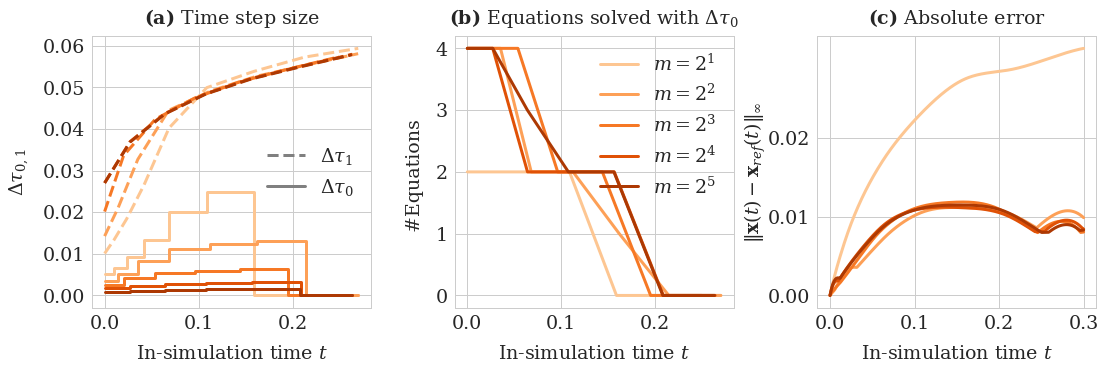

In [7]:
alg = 'EF_local_adap'
params[alg]['write_to_file'] = True
params[alg]['eps'] = 0.005

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18, 5),  gridspec_kw={'hspace':0.2, 'wspace': 0.3})

cmap = cm.get_cmap('Oranges', 15)

m_exponents = [1, 2, 3, 4, 5]
for i, e in enumerate(m_exponents):
    params[alg]['m0'] = 2**e

    try:
        os.remove('n_eq_per_level.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('step_sizes_dt_0.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('step_sizes_dt_1.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
        
    ts, history = models[alg].simulate(cell_list, [0, 0.3], params_cubic, params[alg], seed=seed)
    
    traj = np.array([[cell.position for cell in cell_list] for cell_list in history]) # (N, n_cells, dim)
        
    interp = sci.interp1d(ts, traj, axis=0, bounds_error=False, 
                              kind='cubic', fill_value=tuple(traj[[0, -1], :, :]))(ts_ref[:])
    difference = np.reshape(interp - ref_traj, (-1, dim*len(history[0])))
    

    dt_0s = np.loadtxt('step_sizes_dt_0.txt')
    dt_1s = np.loadtxt('step_sizes_dt_1.txt')
    n_eq_per_level = np.loadtxt('n_eq_per_level.txt')   
    
    if e > 5:
        continue
    
    ax3.plot(ts_ref, np.linalg.norm(difference, ord=np.inf, axis=1), color=cmap(i*2+4))


    ax1.step(ts[:-1], dt_0s, color=cmap(i*2+4), where='post')
    ax1.plot(ts[:-1], dt_1s, linestyle='--', color=cmap(i*2+4))
    
    ax2.plot(ts[:-1], n_eq_per_level[0,:], color=cmap(i*2+4), label='$m=2^'+str(e)+'$')
    

ax2.legend()
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='grey', linestyle='--'),
                Line2D([0], [0], color='grey')]

ax1.legend(custom_lines, [r'$\Delta \tau_1$', r'$\Delta \tau_0$'])
ax1.set(xlabel=r'In-simulation time $t$')
ax1.set(ylabel=r'$\Delta \tau_{0,1}$')
ax2.set(xlabel=r'In-simulation time $t$')
ax2.set(ylabel='#Equations ')
ax3.set(xlabel=r'In-simulation time $t$')
ax3.set_ylabel(r'$\Vert \mathbf{x}(t)- \mathbf{x}_{ref}(t)\Vert_{\infty}$', labelpad=-0.25)
#ax3.set_ylim([-0.003, 0.03])
ax3.set_yticks([0, 0.01, 0.02])

ax1.set_title(r'$\bf{(a)}$ Time step size')
ax2.set_title(r'$\bf{(b)}$ Equations solved with $\Delta \tau_0$')
ax3.set_title(r'$\bf{(c)}$ Absolute error')

plt.savefig('comp_dt_LAFE.pdf', bbox_inches='tight')

In [8]:
initial_tau_1s = {}

In [9]:
alg = 'EF_local_adap'
params[alg]['write_to_file'] = True

for eps in [0.01, 0.005, 0.0025]:
    params[alg]['eps'] = eps

    m_values = range(2, 40, 1)
    initial_tau_1 = []

    for i, m in enumerate(m_values):
        params[alg]['m0'] = m

        try:
            os.remove('n_eq_per_level.txt')
        except FileNotFoundError:
            print('Nothing to delete.')
        try:
            os.remove('step_sizes_dt_0.txt')
        except FileNotFoundError:
            print('Nothing to delete.')
        try:
            os.remove('step_sizes_dt_1.txt')
        except FileNotFoundError:
            print('Nothing to delete.')

        ts, history = models[alg].simulate(cell_list, [0, 0.3], params_cubic, params[alg], seed=seed)    

        dt_1s = np.loadtxt('step_sizes_dt_1.txt')

        initial_tau_1.append(dt_1s[0])

    initial_tau_1s[eps] = initial_tau_1


/home/kubuntu1804/Documents/cbmos/cbmos/cbmodel/__init__.py:335: RuntimeWarning: divide by zero encountered in true_divide
  / (norm + _np.diag(self.hpc_backend.ones(y_r.shape[0]))),
/home/kubuntu1804/Documents/cbmos/cbmos/cbmodel/__init__.py:338: RuntimeWarning: invalid value encountered in multiply
  total_force = (forces * cross_diff).sum(axis=2)  # shape (n, d)
/home/kubuntu1804/Documents/cbmos/cbmos/solvers/euler_forward.py:947: RuntimeWarning: divide by zero encountered in double_scalars
  dt_s = 2.0/abs(w)


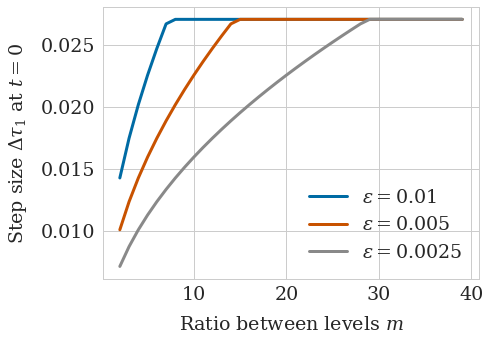

In [11]:
colors = [defcolors[0], defcolors[5], defcolors[6]]

for i, eps in enumerate([0.01, 0.005, 0.0025]):
    plt.plot( m_values, initial_tau_1s[eps], color=colors[i], label='$\epsilon=$'+str(eps))

plt.xlabel('Ratio between levels $m$')
plt.ylabel(r'Step size $\Delta \tau_1$ at $t=0$')
#plt.title('Optimal ratio $m$')
plt.legend()
plt.savefig('optimal_m.pdf', bbox_inches='tight')

It looks like the ratio m doubles if epsilon is halved.

In [28]:
initial_tau_1s[0.005]

[0.011753066595896868,
 0.016621346179391535,
 0.020356908488833963,
 0.023506133191793736,
 0.026280655852507447,
 0.02878901607289698,
 0.03049334012723022,
 0.03049334012723022,
 0.03049334012723022,
 0.03049334012723022,
 0.03049334012723022,
 0.03049334012723022,
 0.03049334012723022,
 0.03049334012723022,
 0.03049334012723022,
 0.03049334012723022,
 0.03049334012723022,
 0.03049334012723022,
 0.03049334012723022]

In [29]:
np.sqrt(8)

2.8284271247461903

In [32]:
np.sqrt(12)

3.7416573867739413

##  Dependence of initial step dt_0 and dt at steady state on spheroid size

Can I run this locally, or should I run this on rackham? Can I maybe run up to 1000 as a script locally? If necessary if I allocate more RAM to the VM?

I want to
- consider all algorithms
- over a range of spheroid sizes
- average over several seeds and hence cell division directions
- calculate dt_0 as ts[1]-ts[0] and dt_st = ts[-2] - ts[-3], since the last time step may be cut short to reach tf exactly. Might need to average over several last steps.

Do I want to plot the level distribution of the locally adaptive algorithm here?

Run script (allows for larger spheroid sizes) and import results here.

`python3 exp-draft_dependence_step_size_n_cells.py`

Results:

- dt_0s_eps0.005_m12.json
- dt_0s_eps0.005_m14.json

In [12]:
import json
with open('dt_0s_eps0.005_m14.json', 'r') as f:
    dt_0s = json.load( f)
    
with open('dt_sts_eps0.005_m14.json', 'r') as f:
    dt_sts = json.load(f)

In [13]:
sizes = [2, 3, 4, 5, 6, 7, 8, 9, 10]

In [30]:
alg = 'EF_local_adap'
params[alg]['write_to_file'] = True
params[alg]['eps'] = 0.005
params[alg]['m0'] = 14
  
tf = 1.0
t_data = [0, tf]
#seeds = [0, 17, 67]
seeds = range(5)
    
n_eqs = {}
for seed in seeds:
    n_eqs[seed] = []
    for l in sizes:
        sheet = ut.setup_locally_compressed_spheroid(l,l,l, seed=seed)    

        try:
            os.remove('n_eq_per_level.txt')
        except FileNotFoundError:
            print('Nothing to delete.')

        ts, history = models[alg].simulate(sheet, t_data, params_cubic, params[alg], seed=seed)

        n_eq_per_level = np.loadtxt('n_eq_per_level.txt')

        n_eqs[seed].append(n_eq_per_level[0,0])

/home/kubuntu1804/Documents/cbmos/cbmos/cbmodel/__init__.py:335: RuntimeWarning: divide by zero encountered in true_divide
  / (norm + _np.diag(self.hpc_backend.ones(y_r.shape[0]))),
/home/kubuntu1804/Documents/cbmos/cbmos/cbmodel/__init__.py:338: RuntimeWarning: invalid value encountered in multiply
  total_force = (forces * cross_diff).sum(axis=2)  # shape (n, d)
/home/kubuntu1804/Documents/cbmos/cbmos/solvers/euler_forward.py:947: RuntimeWarning: divide by zero encountered in double_scalars
  dt_s = 2.0/abs(w)


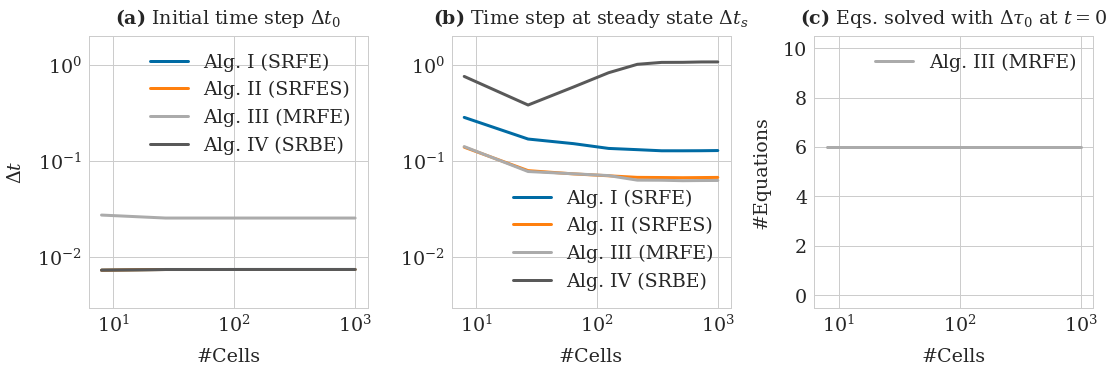

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5), sharex=True, gridspec_kw={'hspace':0.2, 'wspace': 0.3})

ax1.get_shared_y_axes().join(ax1, ax2)
algorithms = ['EF_glob_adap_acc', 'EF_glob_adap_stab' ,  'EF_local_adap', 'EB_global_adap' ]

for alg in algorithms:
    ax1.loglog([l**3 for l in sizes], dt_0s[alg], label=labels[alg])
ax1.legend()
ax1.set_title(r'$\bf{(a)}$ Initial time step $\Delta t_0$')
ax1.set(xlabel='#Cells')
ax1.set(ylabel=r'$\Delta t$')
ax1.set_ylim([0.003, 2])

for alg in algorithms:
    ax2.loglog([l**3 for l in sizes], dt_sts[alg], label=labels[alg])
#ax2.legend()
ax2.set_title(r'$\bf{(b)}$ Time step at steady state $\Delta t_s$')
ax2.set(xlabel='#Cells')
ax2.legend(loc=4)
ax2.set_ylim([0.003, 2])

linestyles = ['-', ':', '--', '-.', '']
for i, seed in enumerate(seeds):
    ax3.plot([l**3 for l in sizes], n_eqs[seed], color=defcolors[2], linestyle=linestyles[i])
ax3.set_ylim([-0.5,10.5])
ax3.set(xlabel='#Cells')
ax3.set(ylabel='#Equations')
ax3.set_title(r'$\bf{(c)}$ Eqs. solved with $\Delta \tau_0$ at $t=0$')
ax3.legend(['Alg. III (MRFE)'])

plt.savefig('dependence_n_cells.pdf', bbox_inches='tight')

The number of equations solved with \Delta tau_0 at t=0 depends on the chosen random seed. However for any given random seed, it is always constant over the number of cells.

## Convergence analysis

In [5]:
# calculate reference solution
dt_ref = 0.0005
tf = 3.0
#N_ref = int(1/dt_ref*tf)+1

cbmodel = cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim)

ts_ref, history = cbmodel.simulate(cell_list, [0, tf], params_cubic, {'dt': dt_ref}, seed=seed)

ref_traj = np.array([[cell.position for cell in cell_list] for cell_list in history]) # (N_ref, n_cells, dim)

In [6]:
ind_t1 = int(0.3/dt_ref)
ind_t2 = int(2.0/dt_ref)

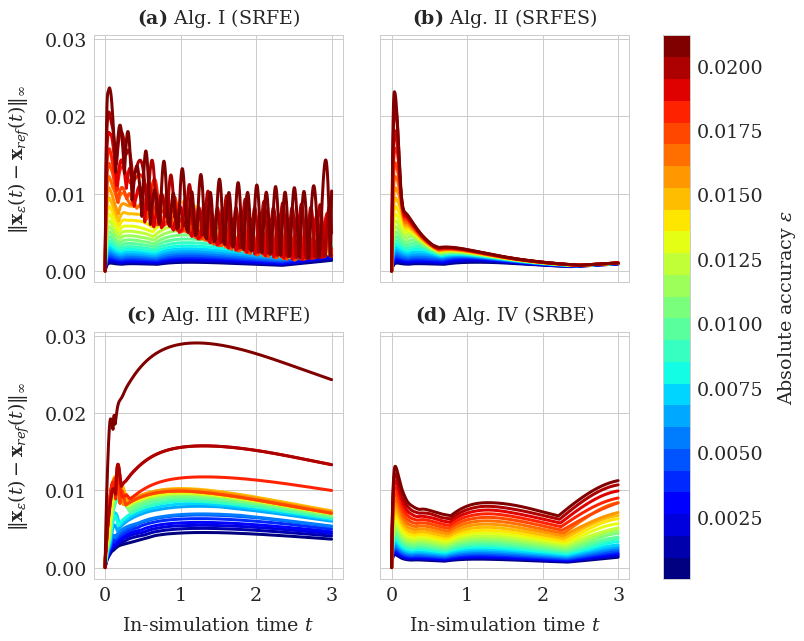

In [7]:
algorithms = ['EF_glob_adap_acc', 'EF_glob_adap_stab' ,  'EF_local_adap', 'EB_global_adap' ]

# Combine into single figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True, gridspec_kw={'hspace':0.2, 'wspace': 0.15})
      
axes = {'EF_glob_adap_acc': ax1, 'EF_glob_adap_stab': ax2 ,  'EF_local_adap': ax3, 'EB_global_adap': ax4}

r = 25
eps_values = np.array([0.0001*1.25**n for n in range(0, r)])
map_eps_values_to_unit_interval = [ np.log(10000*(x-np.min(range(0, r))))/(np.max(range(0, r))-np.min(range(0, r)))/np.log(1.25) for x in eps_values]
colors = [ cm.jet(x) for x in map_eps_values_to_unit_interval ]

sol_int1 = {}
sol_int2 = {}

T_acc_lists = {}

#params['EF_glob_adap_stab']['calculate_eigenvalues'] = True
#params['EF_local_adap']['calculate_eigenvalues'] = True

#params['EF_local_adap']['dim'] = None # full update for reference
#params['EF_local_adap']['dim'] = dim

params['EF_glob_adap_stab']['write_to_file'] = True
params['EF_glob_adap_stab']['out'] = 'EF_glob_adap_stab'
params['EF_local_adap']['write_to_file'] = True
params['EF_local_adap']['out'] = 'EF_local_adap'


for alg in algorithms:
    
    for i, eps in enumerate(eps_values):
        
        params[alg]['eps'] = eps
        
        if alg == 'EF_glob_adap_stab' or alg == 'EF_local_adap':
            try:
                os.remove('step_sizes'+alg+'.txt')
            except FileNotFoundError:
                pass
        
        ts, history = models[alg].simulate(cell_list, [0, tf], params_cubic, params[alg], seed=seed)
        #print(alg+' '+str(eps)+': '+ str(ts[1]-ts[0]))
        
        # calculate accuracy bounded interval
        if alg == 'EF_glob_adap_stab' or alg == 'EF_local_adap':
            dt_all =  np.loadtxt('step_sizes'+alg+'.txt') #[dt, dt_a, dt_s]
            int_acc = np.nonzero(dt_all[:, 0] < dt_all[:, 2])[0]
            T_acc = ts[len(int_acc)-1]
#            if T_acc < dt_ref:
#                print(alg+' '+str(eps)+' '+str(T_acc))
            T_acc_lists.setdefault(alg, []).append(T_acc)
#            ind_t1 = int(np.minimum(T_acc, 1.0)/dt_ref)   
#        elif alg == 'EF_glob_adap_acc':
        #    dt = np.diff(ts[:-1])
        #    dt_s = np.mean(dt[-3:])
        #    int_acc = np.nonzero(dt < 0.90*dt_s)[0] # magic number 90% It might be better to get the info from the algorithm
        #    T_acc = ts[len(int_acc)-1]
        #    T_acc_lists.setdefault(alg, []).append(T_acc)
        #    ind_t1 = int(np.minimum(T_acc, 1.0)/dt_ref)
        #else: # GABE (and GAFE) always accuracy bound
        #    ind_t1 = int(1.0/dt_ref)
        
        
        traj = np.array([[cell.position for cell in cell_list] for cell_list in history]) # (N, n_cells, dim)
        
        interp = sci.interp1d(ts, traj, axis=0, bounds_error=False, 
                              kind='cubic', fill_value=tuple(traj[[0, -1], :, :]))(ts_ref[:])
        difference = np.reshape(interp - ref_traj, (-1, dim*len(history[0])))
        
        error_int1 = np.linalg.norm(np.linalg.norm(difference[:ind_t1], ord=np.inf, axis=1)/np.linalg.norm(np.reshape(ref_traj, (-1, dim*len(history[0])))[:ind_t1], ord=np.inf, axis=1))
        sol_int1.setdefault(alg, []).append(error_int1)
        
        error_int2 = np.linalg.norm(np.linalg.norm(difference[ind_t2:], ord=np.inf, axis=1)/np.linalg.norm(np.reshape(ref_traj, (-1, dim*len(history[0])))[ind_t2:], ord=np.inf, axis=1))
        sol_int2.setdefault(alg, []).append(error_int2)
                
        axes[alg].plot(ts_ref, np.linalg.norm(difference, ord=np.inf, axis=1), color=colors[i])

        
#    axes[alg].legend()

ax1.set_title(r'$\bf{(a)}$ Alg. I (SRFE)')
ax2.set_title(r'$\bf{(b)}$ Alg. II (SRFES)')
ax3.set_title(r'$\bf{(c)}$ Alg. III (MRFE)')
ax4.set_title(r'$\bf{(d)}$ Alg. IV (SRBE)')
    
ax1.set(ylabel=r'$\Vert \mathbf{x}_{\epsilon}(t)- \mathbf{x}_{ref}(t)\Vert_{\infty}$')
ax3.set(ylabel=r'$\Vert \mathbf{x}_{\epsilon}(t)- \mathbf{x}_{ref}(t)\Vert_{\infty}$')  
ax3.set(xlabel=r'In-simulation time $t$')
ax4.set(xlabel=r'In-simulation time $t$')

cma = mcolors.ListedColormap(colors, name='from_list', N=None) # creation of a user cmap
msm = cm.ScalarMappable(cmap=cma) 
msm.set_array(eps_values) 
cbar = fig.colorbar(msm, ax=[ax1, ax2, ax3, ax4])
cbar.set_label('Absolute accuracy $\epsilon$', rotation=90)

plt.savefig('spheroid_errors.pdf', bbox_inches='tight')

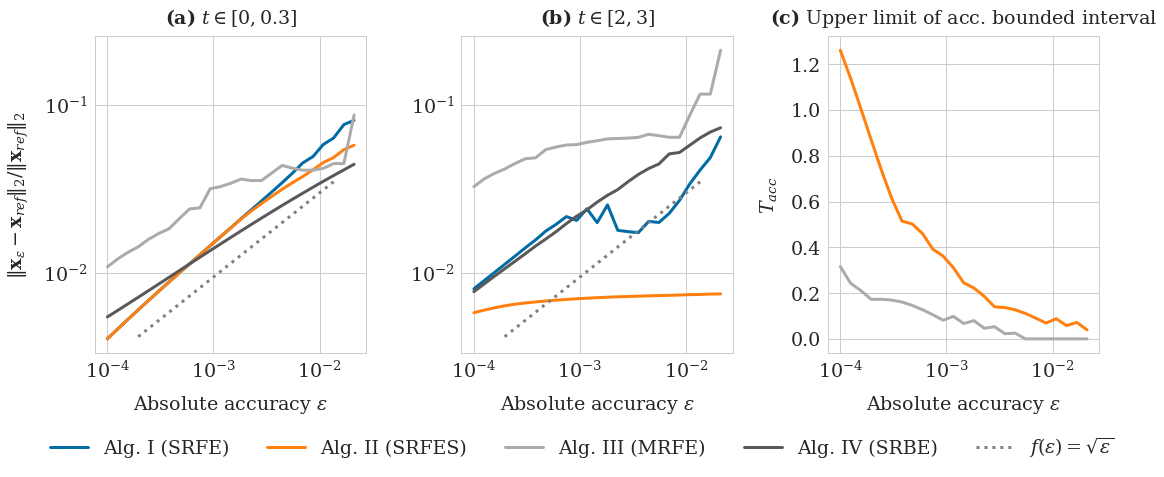

In [38]:
algorithms = ['EF_glob_adap_acc', 'EF_glob_adap_stab' ,  'EF_local_adap', 'EB_global_adap' ]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 7), gridspec_kw={'hspace':0.2, 'wspace': 0.35})
for alg in algorithms:
    ax1.loglog(eps_values, sol_int1[alg], '-', label=labels[alg])
    ax2.loglog(eps_values, sol_int2[alg], '-')


ax1.loglog(eps_values[3:-2], eps_values[3:-2]**0.5*0.3, ':',
           label='$f(\epsilon)= \sqrt{\epsilon}$', color='grey')
ax2.loglog(eps_values[3:-2], eps_values[3:-2]**0.5*0.3, ':',color='grey')
ax1.set(xlabel='Absolute accuracy $\epsilon$')
ax1.set(ylabel=r'$\Vert \mathbf{x}_{\epsilon}-\mathbf{x}_{ref}\Vert_{2}/\Vert \mathbf{x}_{ref}\Vert_{2}$')
ax2.set(xlabel='Absolute accuracy $\epsilon$')

ax1.set_title(r'$\bf(a)$ $ t \in [0, 0.3]$')
ax2.set_title(r'$\bf(b)$ $ t \in [2, 3 ]$')
ax3.set_title(r'$\bf(c)$ Upper limit of acc. bounded interval')


algorithms = ['EF_glob_adap_stab', 'EF_local_adap']
for i, alg in enumerate(algorithms):
    ax3.semilogx(eps_values, T_acc_lists[alg], color=defcolors[i+1])
#ax3.semilogx(eps_values, dt_ref*np.ones(len(eps_values)))
ax3.set(xlabel='Absolute accuracy $\epsilon$')
ax3.set(ylabel=r'$T_{acc}$' )

ax1.get_shared_y_axes().join(ax1, ax2)
fig.legend(loc=8, ncol=5)
fig.subplots_adjust(bottom=0.25)  
#plt.grid(True)
plt.savefig('spheroid_order.pdf', bbox_inches='tight')

In [65]:
from scipy.optimize import least_squares
def f(x, t, y):
    return x[0] * np.log(t) + x[1] - np.log(y)

In [66]:
res = least_squares(f, np.array([1,1]), args=(eps_values, sol_int1['EF_glob_adap_stab']))

In [67]:
res.x

array([ 0.55152313, -0.39856975])

In [68]:
res = least_squares(f, np.array([1,1]), args=(eps_values, sol_int1['EF_local_adap']))

In [69]:
res.x

array([ 0.53286405, -0.01108471])

## Comparison of computational cost

 I might actually be able to run this in a script locally. Might want to save data after every algorithm.
 
 exp-locally_compressed_spheroid.py

Results from old version (exec_times[alg] = data['exec_times'][alg]):
- exp_locally_compressed_spheroid_benchmark_s0.json
- benchmark_size_8_m04_'+alg+'.json
- data_from_cluster/benchmark_size_8_'+alg+'.json
- data_from_cluster/benchmark_size_10_m04_'+alg+'.json'
- data_from_cluster/benchmark_size_10_m04_r2'+alg+'.json'

Results from new version:
- data_from_cluster/v2_benchmark_10
- data_from_cluster/v2_benchmark_11
- data_from_cluster/v2_benchmark_size_10_with_burn-in
- data_from_cluster/v2_benchmark_size_11_with_burn-in
- data_from_cluster/v2_benchmark_size_10_2_ # from here on partial updates included
- data_from_cluster/v2_benchmark_size_11_2_
- data_from_cluster/v2_benchmark_size_12_2_
- data_from_cluster/v2_benchmark_test
- data_from_cluster/v2_benchmark_test4
- data_from_cluster/v2_benchmark_test5
- data_from_cluster/v2_benchmark_test6
- data_from_cluster/v2_benchmark_size_10_use_A_
- data_from_cluster/v3_size_6_

Even better:
- data_from_cluster/20220501_benchmark_size_10_eps0.005_m14s17_'

In [68]:
algorithms = ['EF_glob_adap_acc', 'EF_glob_adap_stab' ,  'EF_local_adap', 'EF_local_adap_stab', 'EB_global_adap', 'fixed_dt' ]
algorithms = ['EF_glob_adap_acc', 'EF_glob_adap_stab' ,  'EF_local_adap_stab', 'EB_global_adap', 'fixed_dt' ]

#algorithms = ['EF_glob_adap_stab', 'EF_local_adap', 'EF_local_adap_stab']
#algorithms = ['EF_glob_adap_acc',  'EF_local_adap', 'fixed_dt' ]
colors = {'EF_glob_adap_acc': defcolors[0], 
          'EF_glob_adap_stab': defcolors[1] ,  
          'EF_local_adap': defcolors[2], 
          'EB_global_adap': defcolors[3], 
          'fixed_dt' : defcolors[4],
          'EF_local_adap_stab':defcolors[5]}
#colors = {'EF_glob_adap_acc': defcolors[0], 
#          'EF_local_adap': defcolors[3], 
#          'fixed_dt' : defcolors[5]}

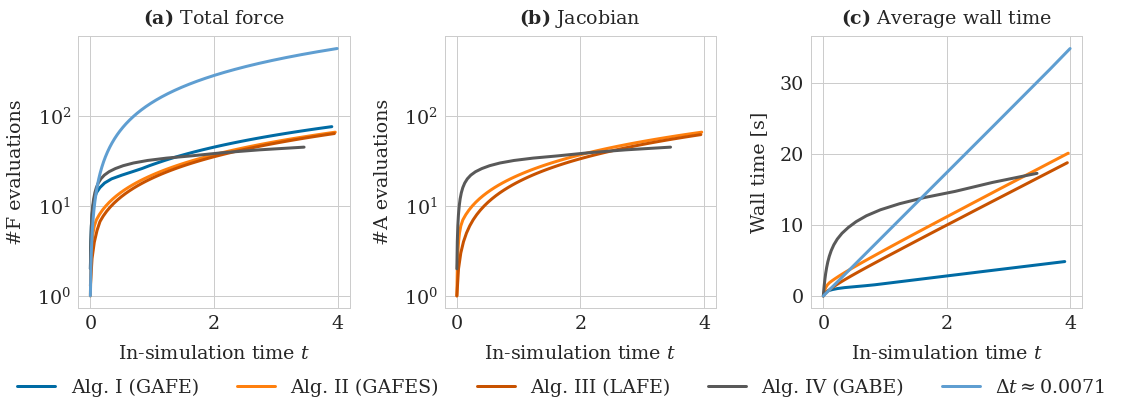

In [70]:
N_cells = 5**3
dim = 3
exec_times = {}
min_exec_times = {}
max_exec_times = {}
ts_s = {}
F_evaluations = {}
A_evaluations = {}
for alg in algorithms:
    #with open('data_from_cluster/20220428_benchmark_size_10_eps0.005_m14s17_'+alg+'.json', 'r') as f:
    with open('data_from_cluster/20220501_benchmark_size_10_eps0.005_m14s17_'+alg+'.json', 'r') as f:
        data = json.load(f) 
        exec_times[alg] = data['exec_times']
        min_exec_times[alg] = data['min_exec_times']
        max_exec_times[alg] = data['max_exec_times']
        ts_s[alg] = data['ts']
        F_evaluations[alg] = np.array(data['F_evals'])
        A_evaluations[alg] = data['A_evals']
        
dt_f = ts_s['fixed_dt'][1] - ts_s['fixed_dt'][0]
labels['fixed_dt'] = r'$\Delta t\approx$'+str(np.round(dt_f, 4))
#labels['EF_local_adap_stab'] ='Alg. IIIb (LAFES)'

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), gridspec_kw={'hspace':0.2, 'wspace': 0.35})

for i, alg in enumerate(algorithms):
    ax3.plot(ts_s[alg][:-1], exec_times[alg], label=labels[alg], color=colors[alg])
#    ax1.plot(ts_s[alg][:-1], min_exec_times[alg], label=labels[alg], linestyle='--', color=defcolors[i])
#    ax1.plot(ts_s[alg][:-1], max_exec_times[alg], label=labels[alg], linestyle=':', color=defcolors[i])
    ax1.semilogy(ts_s[alg][:-1], F_evaluations[alg][:len(ts_s[alg])-1], label=labels[alg],  color=colors[alg])
    ax2.semilogy(ts_s[alg][:-1], A_evaluations[alg][:len(ts_s[alg])-1], label=labels[alg],  color=colors[alg])
#ax2.legend()
ax1.set(xlabel=r'In-simulation time $t$')
ax3.set_ylabel('Wall time [s]')

ax2.set(xlabel=r'In-simulation time $t$')
ax3.set(xlabel=r'In-simulation time $t$')

#fig.legend(['Alg. I (GAFE)',  'Alg. II (GAFES)', 'Alg. III (LAFE)', 'Alg. IIIb (LAFES)', 'Alg. IV (GABE)', r'$\Delta t\approx$'+str(np.round(dt_f, 4))], loc=8, ncol=6)
fig.legend(['Alg. I (SRFE)',  'Alg. II (SRFES)', 'Alg. III (MRFE)', 'Alg. IV (SRBE)', r'$\Delta t\approx$'+str(np.round(dt_f, 4))], loc=8, ncol=6)

#fig.legend([ 'Alg. II (GAFES)', 'Alg. III (LAFE)', 'Alg. IIIb (LAFES)'], loc=8, ncol=6)
#ax1.set_ylim([-0.5, 38])
fig.subplots_adjust(bottom=0.25)

ax1.set_title(r'$\bf{(a)}$ Total force')
ax2.set_title(r'$\bf{(b)}$ Jacobian')
ax3.set_title(r'$\bf{(c)}$ Average wall time')


ax2.get_shared_y_axes().join(ax1, ax2)
#ax3.set_yticklabels([])
ax1.set(ylabel=r'#F evaluations')
ax2.set(ylabel=r'#A evaluations')
plt.savefig('locally_comp_spheroid_benchmark.pdf', bbox_inches='tight')

In [64]:
ts_s['EF_glob_adap_acc'][1] - ts_s['EF_glob_adap_acc'][0]

0.007132468456522988

It makes sense that LAFE is only marginally faster than GAFES since we only use smaller steps at the beginning for very few steps. This means that a proliferation example is becoming more and more important.

I count full force evaluations and partial evaluations as `2*#perturbed/#all`. Since the number of perturbed eqs is independent of the size of the spheroid, the cost of the partial evaluations is negligable for large system sizes (1000 cells or more). Nevertheless, it is not faster than GAFES for `12**3+1` cells.

In [ ]:
algorithms = ['EF_glob_adap_acc',  'EF_local_adap', 'EB_global_adap', 'fixed_dt' ] 

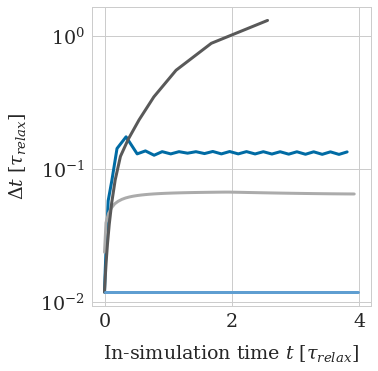

In [37]:
fig = plt.figure(figsize=(5,5.5))

for alg in algorithms:
    plt.semilogy(ts_s[alg][:-2], np.diff(ts_s[alg][:-1]), color=colors[alg] )
plt.xlabel(r'In-simulation time $t$ [$ \tau_{relax}$]')
plt.ylabel(r'$\Delta t \ [\tau_{relax}]$')
plt.savefig('dt_benchmark.pdf', bbox_inches='tight')

## Compare error relative to fixed dt solution

Hmm, since I'm not running this on rackham the random seed will not have the same affect and hence the results will not be completely consistent. Is this a problem? Depends on how I phrase it. Worse case I run it on Rackham. 

How much does the seed affect?

In [23]:
seed = 67
cbmodel = cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim)
#sheet = ut.setup_locally_compressed_spheroid(10, 10, 10, seed=seed)
sheet = ut.setup_locally_compressed_spheroid(10, 10, 10, seed=seed)
tf = 6.0
t_data = [0.0, tf]
dt_f = 0.011758452836496444

In [24]:
ref_ts, ref_sol = cbmodel.simulate(sheet, t_data, params_cubic, {"dt": dt_f}, seed=seed)
ref_traj = np.array(
            [
                [cell.position for cell in cell_list]
                for cell_list in ref_sol
            ]
        ) # (N_ref, n_cells, dim)

In [25]:
#algorithms = ['EF_glob_adap_acc', 'EF_glob_adap_stab' ,  'EF_local_adap', 'EB_global_adap' ]
algorithms = ['EF_glob_adap_acc',  'EF_local_adap', 'EB_global_adap' ]
eps = 0.01
for alg in algorithms:
    params[alg]['eps'] = eps

In [26]:
params['EF_glob_adap_stab']['calculate_eigenvalues'] = False
params['EF_local_adap']['calculate_eigenvalues'] = False

params['EF_local_adap']['dim'] = 3

params['EF_glob_adap_stab']['write_to_file'] = False
params['EF_local_adap']['write_to_file'] = False

error = {}
for alg in algorithms:
    ts, history = models[alg].simulate(sheet, t_data, params_cubic, params[alg], seed=seed)
    
    traj = np.array([[cell.position for cell in cell_list] for cell_list in history]) # (N, n_cells, dim)    
    
    interp = sci.interp1d(ts, traj, axis=0, bounds_error=False, kind='cubic', fill_value=tuple(traj[[0, -1], :, :]))(ref_ts[:])

    difference = np.reshape(interp - ref_traj, (-1, dim*len(history[0])))
    
    error[alg] = np.linalg.norm(difference, ord=np.inf, axis=1)
        

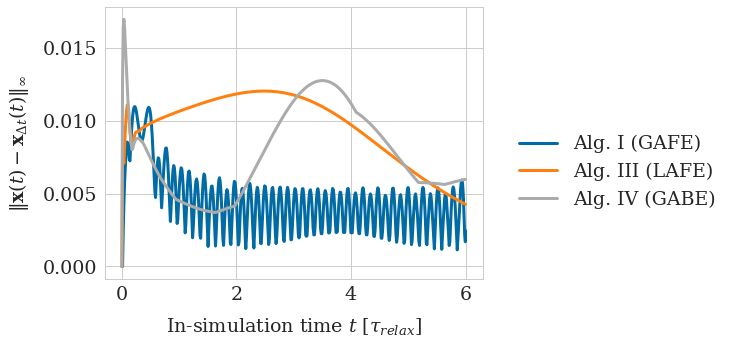

In [29]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
for alg in algorithms:
    ax.plot(ref_ts, error[alg], label=labels[alg]) 

fig.legend(loc=7)
fig.subplots_adjust(right=0.65)  

ax.set(xlabel=r'In-simulation time $t$ [$ \tau_{relax}$]')
ax.set(ylabel=r'$\Vert \mathbf{x}(t) - \mathbf{x}_{\Delta t}(t)\Vert_{\infty}$')
plt.savefig('locally_comp_spheroid_error.pdf', bbox_inches='tight')